# **Lab 4.1 Data Augmentation with PyTorch**

In [2]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [ ]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Pad(20, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10, expand=True),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor()
    ])

    dataset = ImageFolder(path, transform=transform)


    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    return data_loader

    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


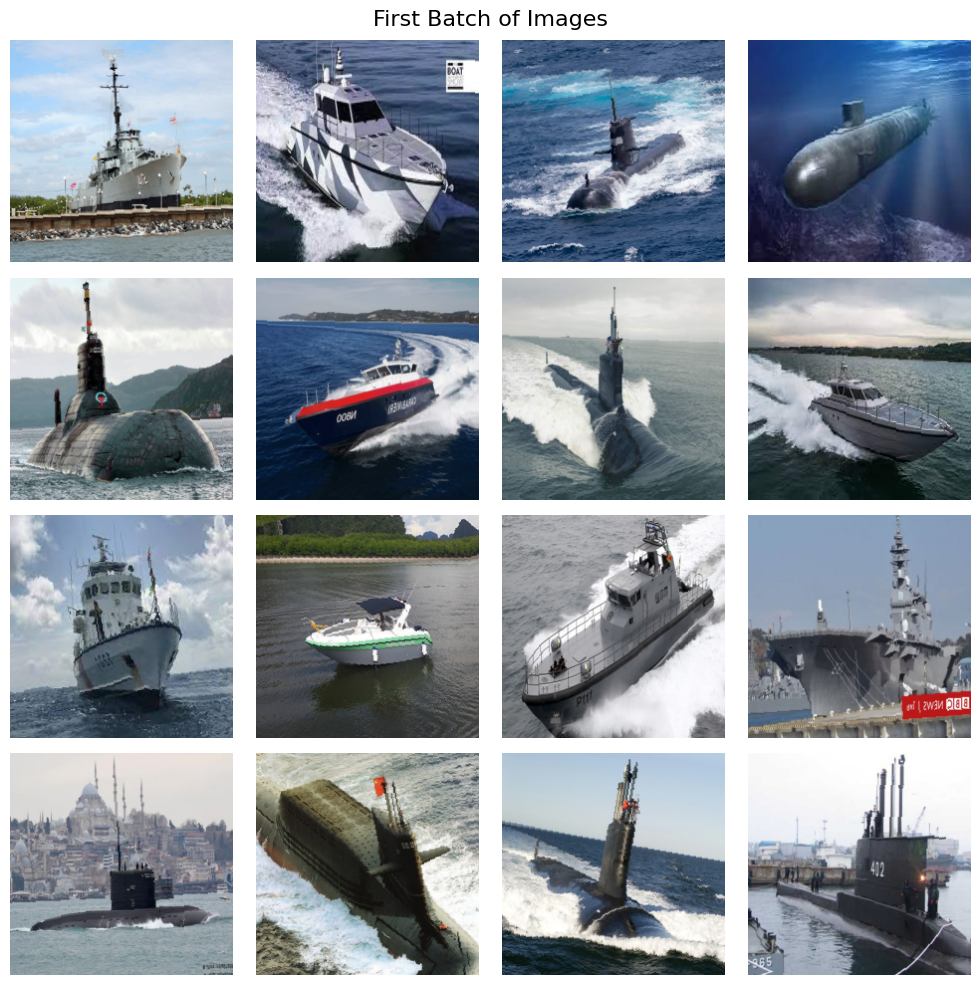

In [3]:
### START CODE HERE ###
data_loader = load_data("./Ship/Train")
# Display first batch of image
images, labels = next(iter(data_loader))

# Convert tensor images to numpy arrays for plotting
def imshow(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
    plt.imshow(img)
    plt.axis('off')

# Plot images in a grid (4x4 for batch of 16)
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
plt.suptitle("First Batch of Images", fontsize=16)
plt.tight_layout()
plt.show()


### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [24]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, path):
        self.dataset = ImageFolder(
            path,
            transform=None  # We'll handle transforms manually
        )
        self.resize = transforms.Resize((224, 224))

    def __len__(self):
        return len(self.dataset)

    def add_gaussian_blur(self, image, ksize=5):
        img_np = image.permute(1, 2, 0).numpy()
        img_np = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
        img_np = np.clip(img_np, 0, 1)
        return torch.from_numpy(img_np).permute(2, 0, 1).float()

    def add_gaussian_noise(self, image, mean=0, var=0.01):
        img_np = image.permute(1, 2, 0).numpy()
        noisy = random_noise(img_np, mode='gaussian', mean=mean, var=var)
        noisy = np.clip(noisy, 0, 1)
        return torch.from_numpy(noisy).permute(2, 0, 1).float()

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Resize PIL image before converting to tensor
        img = self.resize(img)
        img = transforms.ToTensor()(img)
        # Randomly apply augmentation
        if random.random() < 0.5:
            img = self.add_gaussian_blur(img)
        if random.random() < 0.5:
            img = self.add_gaussian_noise(img)
        return img, label
    
### END CODE HERE ###

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

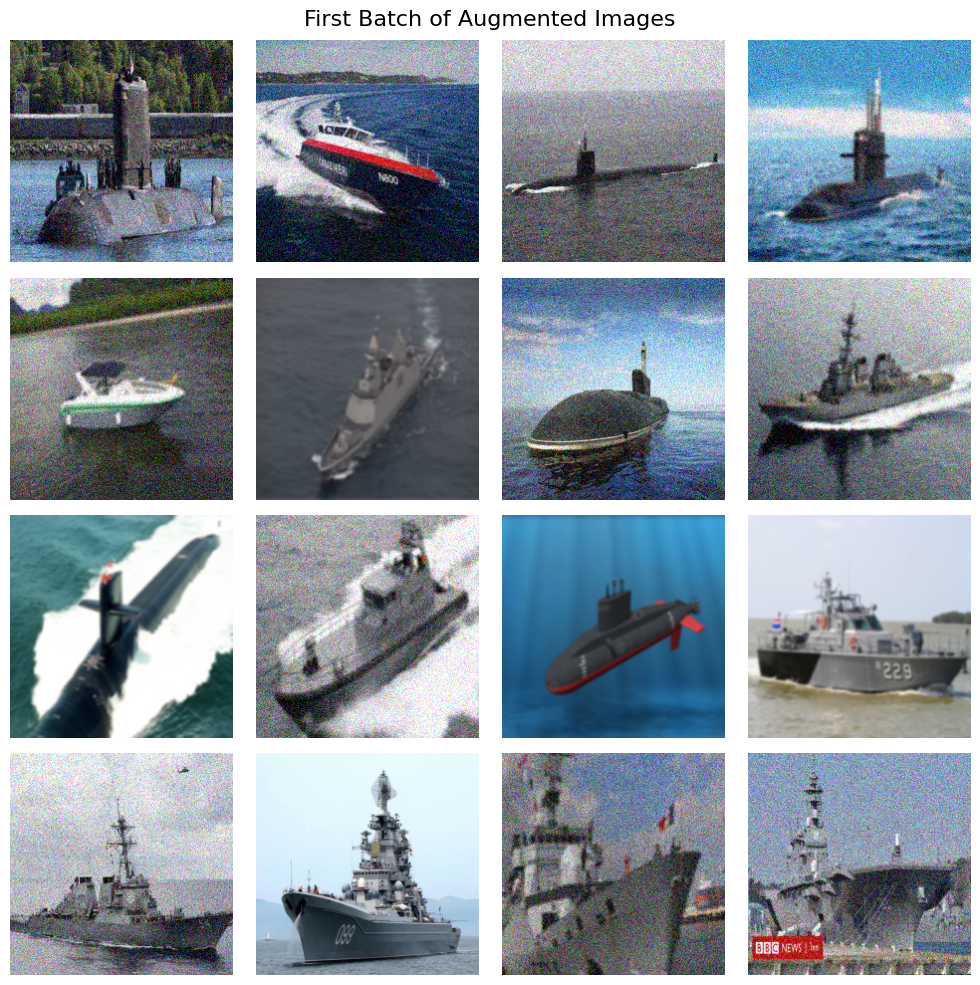

In [25]:
### START CODE HERE ###
dataset = CustomImageDataset("./Ship/Train")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Display first batch of images
images, labels = next(iter(dataloader))

def imshow(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
plt.suptitle("First Batch of Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()


### END CODE HERE ###

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?

# Answer
1. fill_mode จะเติมสีจนเต็มรูป แต่ padding_mode จะต้องกำหนดระยะที่จะเติม pixel ในรูป
2. ควร augment ตามเป้าหมายที่จะนำ model ไปใช้จะทำให้ model ทำงานได้ดี แต่ก็ไม่ควร augment จนดูรูปไม่รู้เรื่องว่าเป็นรูปอะไร
3. Salt-and-pepper noise จะเป็นการสุ่ม pixel ในรูปแล้ว เปลียนเป็นค่า 0 หรือ 255 (ดำหรือขาว) ผลกระทบของ salt และ pepper ขึ้นกับ tone ของรูปต้นฉบับถ้ารูปโทนมืดแบบ salt จะมากกว่า แต่ถ้าเป็น tone สว่างแบบ pepper จะมากกว่า
4. ใช้ ElasticTransform จะใกล้เคียงที่สุด เพราะสามารถบิดภาพให้เหมือน Lens Distortion แต่ถ้าอยากให้เหมือนมากกว่านี้ก็สร้าง function ในการ ทำ
Barrel Distortion และ Pincushion Distortion ขึ้นมาเอง